### Audio Feature Analysis

The goal of this analysis is to 'map out' regions whose activity tracks with the RMSE of the speech soundtrack.
This script will load a variable 'resampled_audio_feature', which contains the time-varying RMSE (roughly, the sound energy) as a variable. This variable has been resampled to match the temporal resolution of fMRI (because speech is much faster). Moreover, when we correlate this audio-feature against the fmri-data, we will account for the time-delay between the sound and the fMRI response (so-called hemodynamic lag). Note that this analysis is based on simple correlations rather than a full GLM-style analysis (see Huettel, 2008). A GLM has been run (including second level testing) and yields the same results. The forward correlation analysis shown here is simply a more straightforward way to demonstrate the relationship between the RMSE feature and the group-level fMRI time course (and see below for individual level test).

In [79]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load relevant data

1. extracted audiofeature (RMSE)
2. extracted fMRI data

In [80]:
resampled_audio_feature = np.load('../data_pieman/resampled_audio_feature.npy')
print(resampled_audio_feature.shape)

fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)

(300,)
(68, 300, 293)


### Group-average the fMRI data

In [81]:
resmat_all = np.nanmean(fmri_data, axis = 0)
resmat_all.shape

(300, 293)

In [82]:
resmat_individual = fmri_data
resmat_individual.shape

(68, 300, 293)

### Correlate the time-varying audio-feature against the neural measuements (for each region)

In [84]:
res = []
tr_shift = 3

for i in range(268):
    #print(i)
    res.append(np.corrcoef(resmat_all[tr_shift:,i], resampled_audio_feature[:-tr_shift])[0,1])
    
#plt.plot(res);

print(np.argmax(res))

print(np.max(res))

162
0.3539958651763675


In [86]:
#np.where(np.asarray(res)>0.15)

(array([ 36,  39,  45,  60,  61, 162, 169, 172, 179, 180, 190]),)

In [87]:
res[61]

0.32154256081328164

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


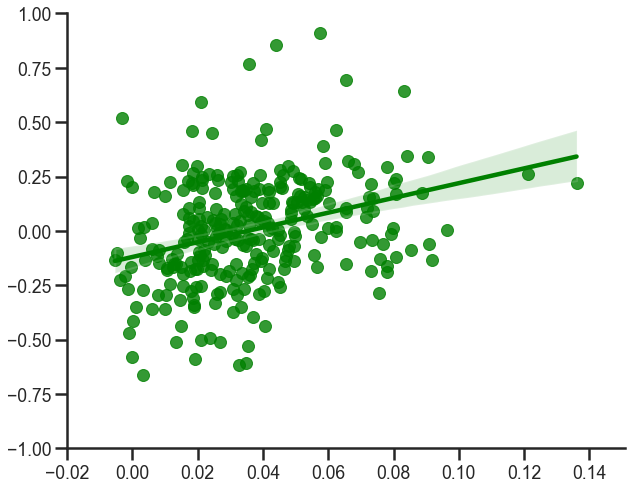

In [88]:
i = 61

sns.set_style('ticks')
plt.figure(figsize = (10, 8))
sns.regplot(
            resampled_audio_feature[:-tr_shift],
            resmat_all[tr_shift:,i], 
            color = 'Green')
plt.ylim([-1,1])
plt.xlim([-0.02,0.151])

sns.despine()

8000


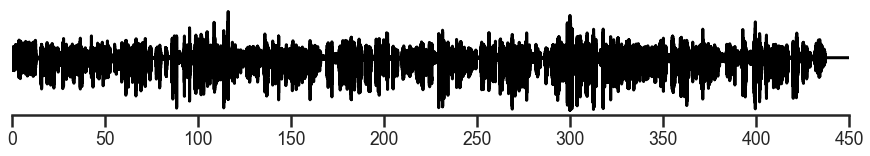

In [89]:
import seaborn as sns
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.io import wavfile

sound_file = '../data_pieman/pieman.wav'
samplerate, sounddata = wavfile.read(sound_file)
#print(data.shape[0]/samplerate)
print(samplerate)
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')

plt.figure(figsize= (15,2));
plt.plot(sounddata, color ='black');
plt.xlim([0,sounddata.shape[0]]);
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0, sounddata.shape[0]]);
plt.xticks(np.arange(0,sounddata.shape[0]+1, 50*samplerate), np.arange(0,451,50));
#plt.xticklabels(np.arange(0,450,50));


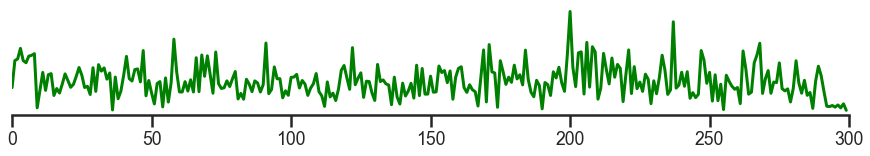

In [90]:
plt.figure(figsize= (15,2));

plt.plot(resampled_audio_feature, color = 'green')
sns.despine(left=True);
plt.yticks([]) ;
plt.xlim([0,300]);

#plt.xticklabels(np.arange(0,450,50));

### Load the brain parcellation to visualize the results

In [91]:
shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'
'''
nilearn.plotting.plot_roi(shen_file, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 );'''
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

### Threshold the results and visualize: Which brain regions track with the audio-feature?

(1, 268)


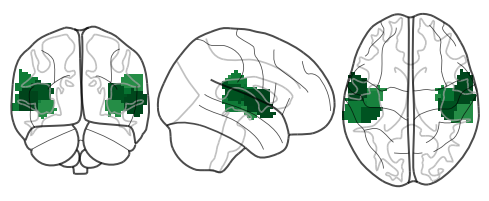

In [92]:
res = np.asarray(res)
res[res < 0.1] = 0

r2 = np.reshape(res, (1,268))
print(r2.shape)

res_img = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=False, 
                          annotate = False,
                          cmap="Greens", 
                          threshold=0.15,
                          plot_abs=False, 
                          #display_mode='x',
                          #figure=plt.figure(figsize=(4, 4)),
                         );

(1, 268)


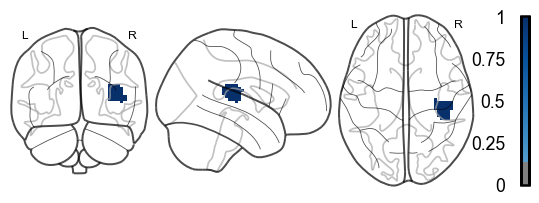

In [93]:


r2 = np.zeros((1,268))
r2[0,61] = 1
print(r2.shape)

res_img = shen_masker.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=True, 
                          annotate = True,
                          cmap="Blues", 
                          threshold=0.15,
                          plot_abs=False, 
                          #display_mode='x',
                          #figure=plt.figure(figsize=(4, 4)),
                         );

### For comparison: Brain regions involved in "all things auditory" (from NeuroSynth.org)

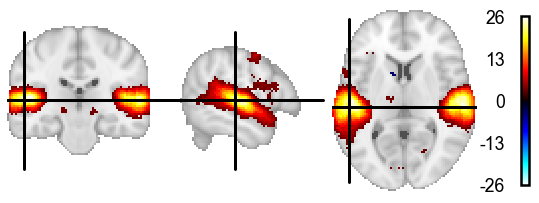

In [94]:
plotting.plot_stat_map('../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=True, 
                          annotate = False,
                          #cmap = 'Greens',
                          #threshold=6.15,
                          #plot_abs=True, 
                         # display_mode='x',
                         # figure=plt.figure(figsize=(4, 4)),
                         );

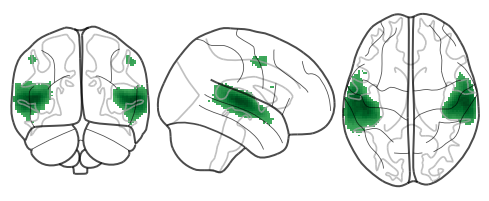

In [95]:
plotting.plot_glass_brain('../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
                          colorbar=False, 
                          cmap = 'Greens',
                          annotate = False,
                          threshold=6.15,
                          plot_abs=True, 
                          #display_mode='x',
                         # figure=plt.figure(figsize=(4, 4)),
                         );

### Individual-level

In [96]:
i = 61
i

61

In [97]:
tr_shift = 3

np.corrcoef(resmat_all[tr_shift:,i], resampled_audio_feature[:-tr_shift])[0,1]
    
np.corrcoef(resmat_all[tr_shift:,i], resampled_audio_feature[:-tr_shift])[0,1]


0.32154256081328164

In [98]:
res =[]
n_subs = resmat_individual.shape[0]
n_shuf = 100



res_shuf = np.zeros((n_subs, n_shuf))

for curr_sub in range(n_subs):
    res.append(np.corrcoef(resmat_individual[curr_sub, tr_shift:, i], resampled_audio_feature[:-tr_shift])[0,1])
    
    for curr_shuf in range(n_shuf):
    
        rf = resampled_audio_feature[:-tr_shift].copy()
        np.random.shuffle(rf)
        res_shuf[curr_sub, curr_shuf] = np.corrcoef(resmat_individual[curr_sub, tr_shift:, i], rf)[0,1]
 
res

[-0.02424842105942803,
 0.19832882154715678,
 0.13797879800845314,
 0.13737796071406322,
 0.03618044903798675,
 -0.005402085449633313,
 0.036066395198040245,
 -0.004133706524767243,
 0.00995981109013121,
 0.0858970938509731,
 0.024189748440900386,
 0.09766892145404453,
 0.13589749155249056,
 0.05093202497684669,
 0.06066333436827391,
 0.2438821036100539,
 0.001883521156616455,
 0.09840575491771332,
 -0.14457233182101192,
 0.18187350041004496,
 0.09865627238392537,
 0.22850824960207725,
 0.12509121583054802,
 -0.12290196915775561,
 -0.005612974648037877,
 0.11629811241951171,
 0.013225468187285016,
 0.1334447018793108,
 0.1755886848551466,
 0.10988467155832479,
 0.17026097524286993,
 -0.01649320801511713,
 0.2424900110374023,
 0.15240933311381516,
 0.07747735218976756,
 0.11406843164372206,
 0.0990327007353613,
 0.09647330869762513,
 0.06764398042577638,
 0.05535356798932316,
 0.09395766831259682,
 -0.06037047763493932,
 0.20617590492244156,
 -0.05391566694752863,
 -0.11404874469668527,

(array([ 3.,  0.,  6.,  8.,  4., 11., 17.,  8.,  6.,  5.]),
 array([-0.14457233, -0.10572689, -0.06688144, -0.028036  ,  0.01080944,
         0.04965489,  0.08850033,  0.12734577,  0.16619122,  0.20503666,
         0.2438821 ]),
 <BarContainer object of 10 artists>)

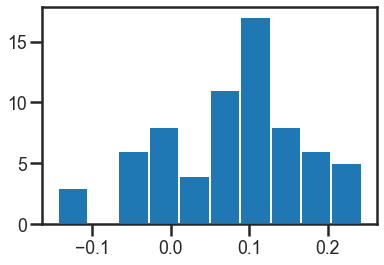

In [99]:
plt.hist(res)

In [100]:
from scipy import stats
stats.ttest_1samp(res, 0)

Ttest_1sampResult(statistic=7.272459473020277, pvalue=4.917922497979346e-10)

In [101]:
np.mean(res)

0.07771175328328439

In [111]:
res_shuf1 = np.mean(res_shuf, axis=0)

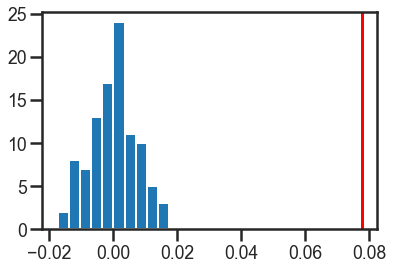

In [112]:
plt.hist(res_shuf1)
plt.axvline(np.mean(res), color = 'red')

In [ ]:
#res_img = shen_masker.inverse_transform(r2);
#view = nilearn.plotting.view_img(  nilearn.image.index_img(res_img,0), 
#                                     threshold = 0.0, 
#                                     vmax = 0.2, 
#                              );
#view

In [ ]:
#view = nilearn.plotting.view_img(  '../data_pieman/auditory_association-test_z_FDR_0.01.nii.gz', 
#                                     threshold = 0.0, 
#                                     #vmax = 0.2, 
#                              );
#view

In [113]:
resmat_all.shape

(300, 293)

In [114]:
from scipy.stats import zscore

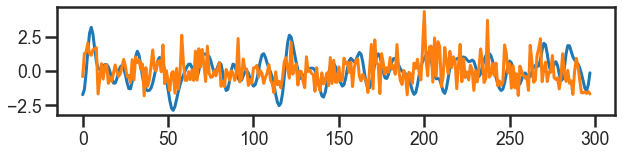

In [115]:
plt.figure(figsize = (10,2))
plt.plot(zscore(resmat_all[2:,162]));
plt.plot(zscore(resampled_audio_feature[:-2]));

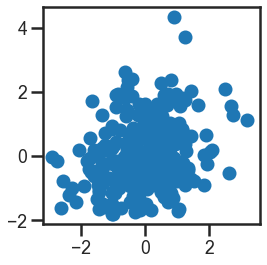

In [116]:
plt.scatter(zscore(resmat_all[2:,162]),
            zscore(resampled_audio_feature[:-2]));
plt.axis('square');